# Rotosolve optimizer

### Create diagram

In [1]:
from lambeq import BobcatParser

parser = BobcatParser()
train_diagram = parser.sentence2diagram('Alice loves Bob')

### Create circuits

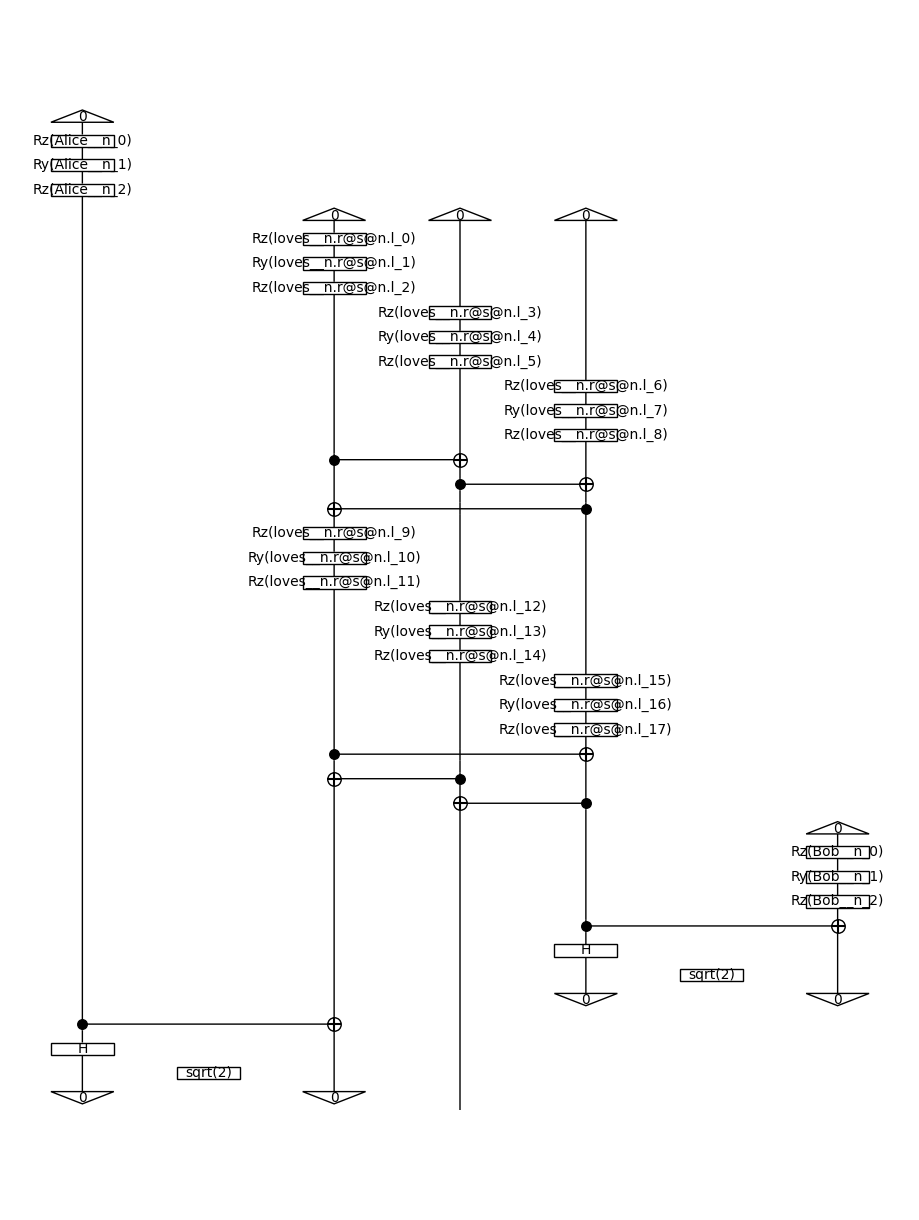

In [2]:
from lambeq import StronglyEntanglingAnsatz, AtomicType

ansatz = StronglyEntanglingAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                                   n_layers=2, n_single_qubit_params=3)

train_circuit = ansatz(train_diagram)

train_circuit.draw(figsize=(9, 12))

### Parameterise

In [3]:
from lambeq import NumpyModel

model = NumpyModel.from_diagrams([train_circuit], use_jit=True)
model.initialise_weights()
model([train_circuit]).shape

(1, 2)

### Define evaluation metric

In [4]:
from jax import jit

@jit
def loss(y_pred, _):
    """The goal is to minimise the expectation value of the Pauli Z operator.
    DisCoPy does not provide functionality to directly calculate expectation
    values. Therefore, we need to calculate the expectation value from the
    measurement probabilities of the Ket(0) and Ket(1) using their
    eigenvalues."""

    # 0 state probability
    p0 = y_pred[:, 0]
    # 1 state probability
    p1 = y_pred[:, 1]

    # expectation value
    exp = p0 - p1  # eigenvalues are 1 and -1

    return - exp.mean()  # minimise expectation of measuring a 1

loss(model([train_circuit]), None)

Array(0.35246935, dtype=float32)

In [5]:
from lambeq import Dataset

train_dataset = Dataset(
            [train_circuit],
            [-1])

### Initialize trainer

In [6]:
from lambeq import QuantumTrainer
from lambeq import RotosolveOptimizer
from tqdm import trange

EPOCHS = 5

losses = []

for i in trange(20):  # calculate results for 100 different seeds

    trainer = QuantumTrainer(
        model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=RotosolveOptimizer,
        optim_hyperparams={},
        evaluate_on_train=True,
        verbose = 'suppress',
        seed=i
    )

    initial_loss = loss(trainer.model([train_circuit]), None)

    trainer.fit(train_dataset, log_interval=12)
    losses.append([initial_loss] + trainer.train_epoch_costs)

100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


### Show results

In [7]:
# get mean and std of the losses
import numpy as np

mean_losses = np.mean(losses, axis=0)
std_losses = np.std(losses, axis=0)

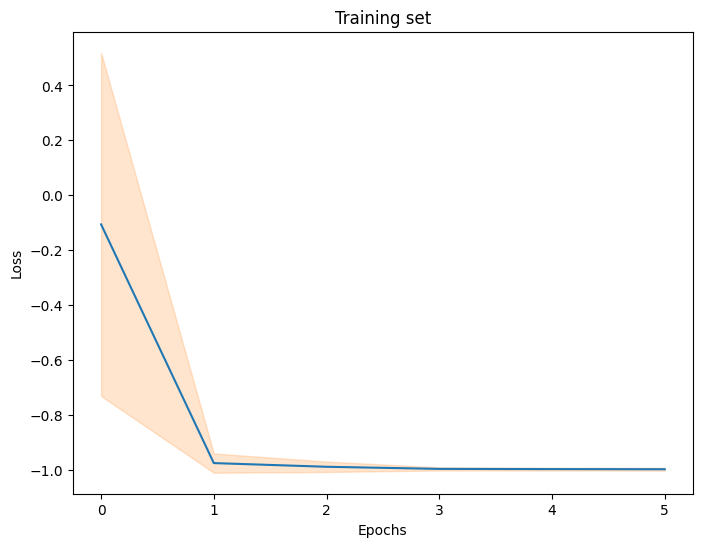

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Training set')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax.plot(mean_losses, color=next(colours));
ax.fill_between(range(len(mean_losses)), mean_losses-std_losses, mean_losses+std_losses, alpha=0.2, color=next(colours));

## Final output

In [9]:
model([train_circuit]).round(3)

Array([[1., 0.]], dtype=float32)